In [ ]:
!pip install scikit-learn pandas rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=d8cdbfae14402bd8a6a9e175de162cfdfd8bf27f2da1815a53a4cc5037b918ab
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge-score


In [ ]:
import pandas as pd
from sentence_transformers import SentenceTransformer, util
from rouge_score import rouge_scorer

# Load SentenceTransformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Load data
dynamic_df = pd.read_csv("/content/dynamic_result.csv")
non_dynamic_df = pd.read_csv("/content/non_dynamic_result.csv")
test_df = pd.read_csv("/content/test_random_400-2.csv")

# Ensure string types
generated_about_dynamic = dynamic_df["Generated About"].astype(str).tolist()
generated_about_non_dynamic = non_dynamic_df["Generated About"].astype(str).tolist()
reference_html = test_df["description_html_clean"].astype(str).tolist()

# Compute dense cosine and ROUGE scores
def compute_metrics_dense(predictions, references):
    scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)

    rouge1_list, rouge2_list, rougeL_list, cosine_list = [], [], [], []

    for pred, ref in zip(predictions, references):
        scores = scorer.score(ref, pred)
        rouge1_list.append(scores["rouge1"].fmeasure)
        rouge2_list.append(scores["rouge2"].fmeasure)
        rougeL_list.append(scores["rougeL"].fmeasure)

    # Compute dense cosine similarity all at once
    pred_embeddings = model.encode(predictions, convert_to_tensor=True, normalize_embeddings=True)
    ref_embeddings = model.encode(references, convert_to_tensor=True, normalize_embeddings=True)
    cosine_scores = util.cos_sim(pred_embeddings, ref_embeddings).diagonal().tolist()

    return rouge1_list, rouge2_list, rougeL_list, cosine_scores

# Compute metrics
r1_dyn, r2_dyn, rl_dyn, cos_dyn = compute_metrics_dense(generated_about_dynamic, reference_html)
r1_non, r2_non, rl_non, cos_non = compute_metrics_dense(generated_about_non_dynamic, reference_html)

# Combine results into DataFrame
result_df = pd.DataFrame({
    "generated_about_dynamic": generated_about_dynamic,
    "generated_about_non_dynamic": generated_about_non_dynamic,
    "description_html_clean": reference_html,
    "ROUGE-1_dynamic": r1_dyn,
    "ROUGE-2_dynamic": r2_dyn,
    "ROUGE-L_dynamic": rl_dyn,
    "cosine_dynamic_dense": cos_dyn,
    "ROUGE-1_non_dynamic": r1_non,
    "ROUGE-2_non_dynamic": r2_non,
    "ROUGE-L_non_dynamic": rl_non,
    "cosine_non_dynamic_dense": cos_non,
})

# Save to CSV
result_df.to_csv("comparison_result.csv", index=False)
print("File 'comparison_result.csv' created")

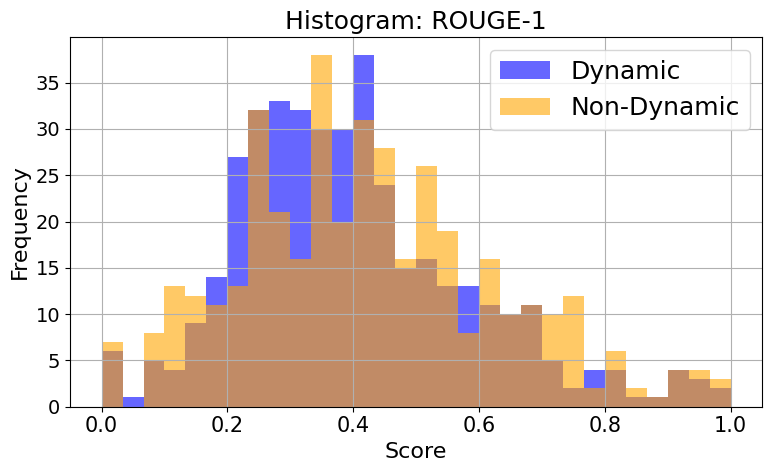

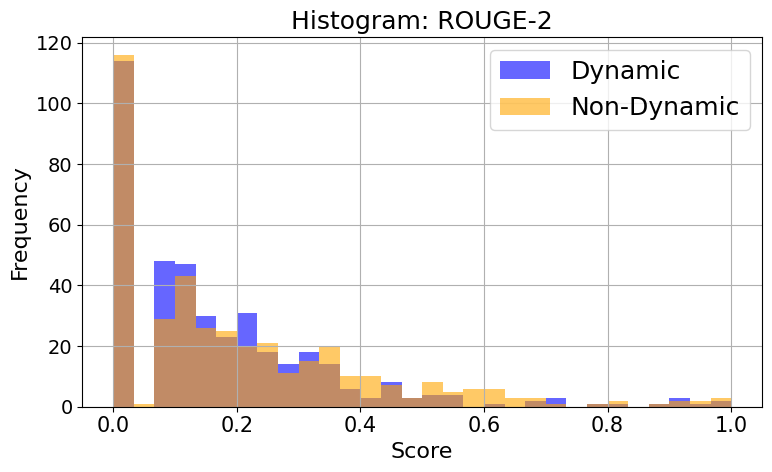

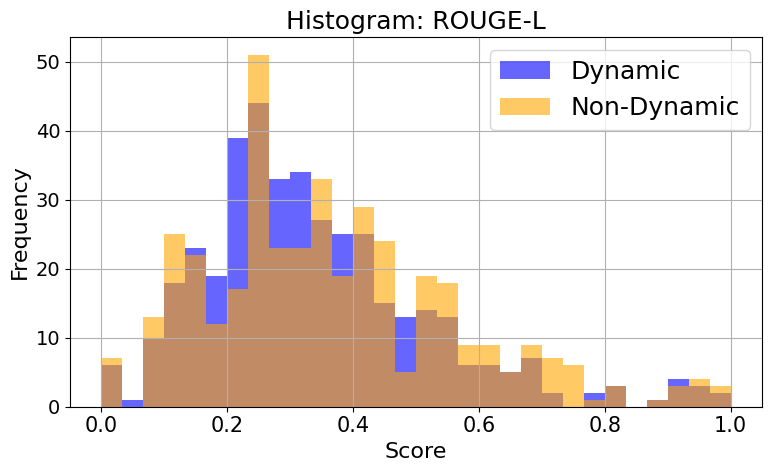

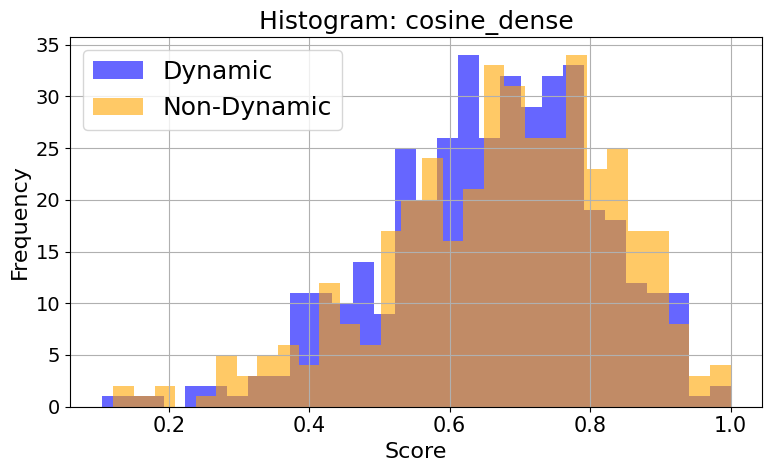

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_csv("/content/comparison_result.csv")

metrics = [
    ("ROUGE-1_dynamic", "ROUGE-1_non_dynamic"),
    ("ROUGE-2_dynamic", "ROUGE-2_non_dynamic"),
    ("ROUGE-L_dynamic", "ROUGE-L_non_dynamic"),
    ("cosine_dynamic_dense", "cosine_non_dynamic_dense")
]

for dyn_col, non_dyn_col in metrics:
    plt.figure(figsize=(8, 5))
    plt.hist(df[dyn_col], bins=30, alpha=0.6, label="Dynamic", color="blue")
    plt.hist(df[non_dyn_col], bins=30, alpha=0.6, label="Non-Dynamic", color="orange")
    plt.xlabel("Score")
    plt.ylabel("Frequency")
    plt.title(f"Histogram: {dyn_col.replace('_dynamic', '')}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [1]:
import pandas as pd


df = pd.read_csv("/content/comparison_result-2.csv")


avg_metrics = {
    "ROUGE-1_dynamic": df["ROUGE-1_dynamic"].mean(),
    "ROUGE-2_dynamic": df["ROUGE-2_dynamic"].mean(),
    "ROUGE-L_dynamic": df["ROUGE-L_dynamic"].mean(),
    "cosine_dynamic_dense": df["cosine_dynamic_dense"].mean(),

    "ROUGE-1_non_dynamic": df["ROUGE-1_non_dynamic"].mean(),
    "ROUGE-2_non_dynamic": df["ROUGE-2_non_dynamic"].mean(),
    "ROUGE-L_non_dynamic": df["ROUGE-L_non_dynamic"].mean(),
    "cosine_non_dynamic_dense": df["cosine_non_dynamic_dense"].mean(),
}

print("Average Scores:")
for k, v in avg_metrics.items():
    print(f"{k}: {v:.4f}")

Average Scores:
ROUGE-1_dynamic: 0.3971
ROUGE-2_dynamic: 0.1722
ROUGE-L_dynamic: 0.3397
cosine_dynamic_dense: 0.6567
ROUGE-1_non_dynamic: 0.4222
ROUGE-2_non_dynamic: 0.2039
ROUGE-L_non_dynamic: 0.3652
cosine_non_dynamic_dense: 0.6734


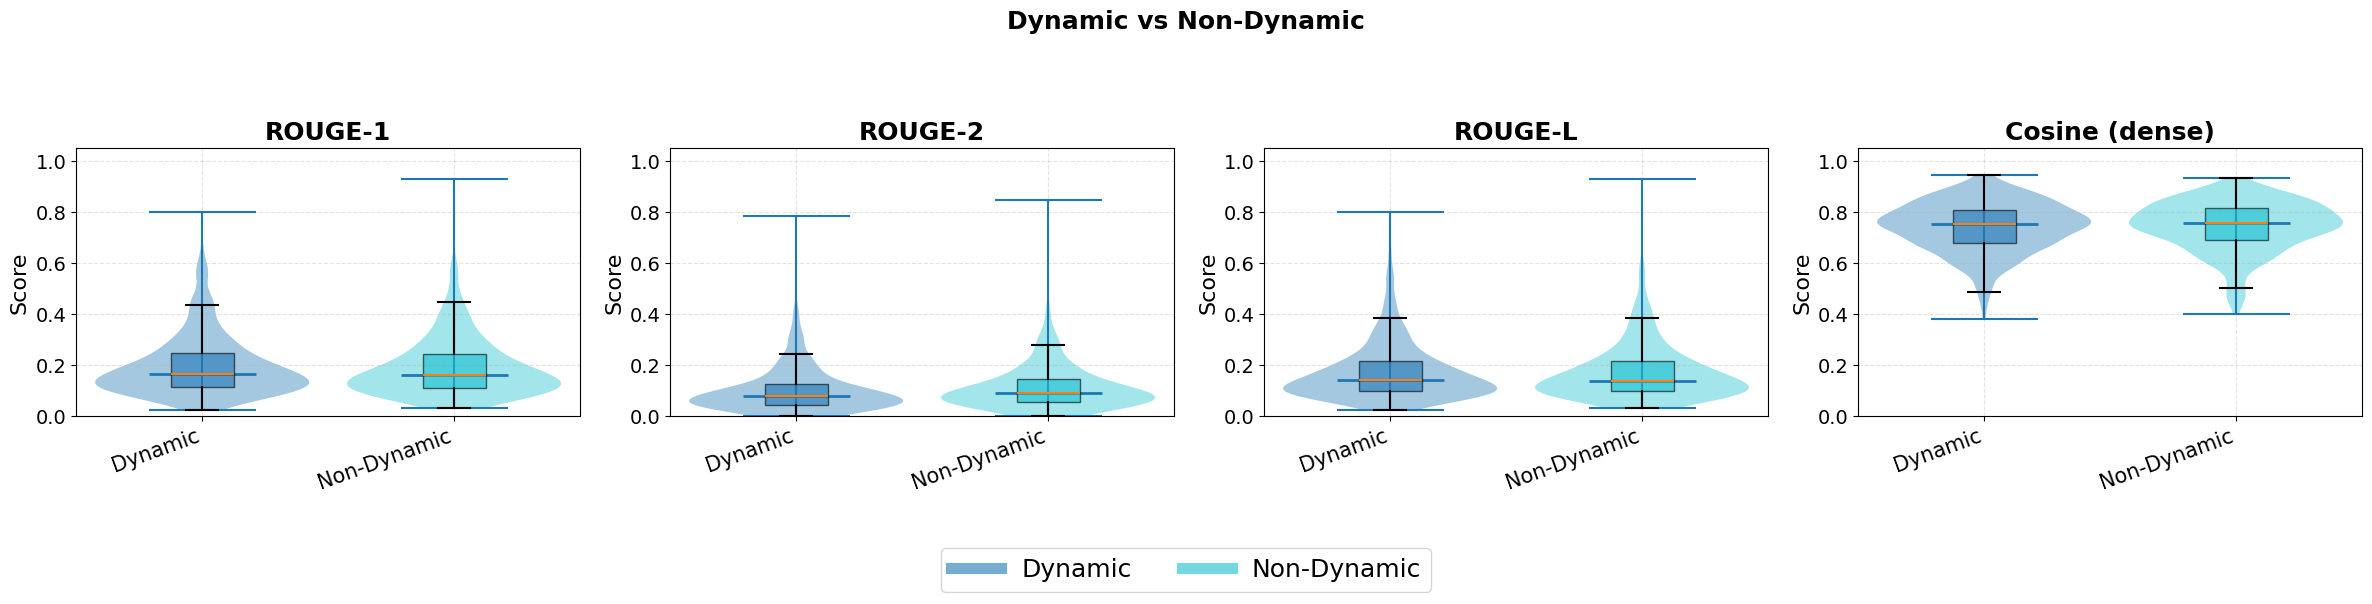

In [ ]:


from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# ===== CONFIG =====
INPUT_CSV = Path("/content/comparison_result.csv")

MODEL_NAME_MAP = {
    "dynamic": "Dynamic",
    "non_dynamic": "Non-Dynamic",
}

METRIC_COLS = {
    "1": ("ROUGE-1_dynamic", "ROUGE-1_non_dynamic"),
    "2": ("ROUGE-2_dynamic", "ROUGE-2_non_dynamic"),
    "L": ("ROUGE-L_dynamic", "ROUGE-L_non_dynamic"),
    "C": ("cosine_dynamic_dense", "cosine_non_dynamic_dense"),
}
METRIC_TITLES = {"1": "ROUGE-1", "2": "ROUGE-2", "L": "ROUGE-L", "C": "Cosine (dense)"}



def load_scores_from_comparison(df: pd.DataFrame) -> dict[str, dict[str, np.ndarray]]:
    all_scores: dict[str, dict[str, np.ndarray]] = {v: {} for v in MODEL_NAME_MAP.values()}
    for mkey, (col_dyn, col_non) in METRIC_COLS.items():
        arr_dyn = pd.to_numeric(df.get(col_dyn, []), errors="coerce").to_numpy(dtype=float)
        arr_non = pd.to_numeric(df.get(col_non, []), errors="coerce").to_numpy(dtype=float)
        for name, arr in [("Dynamic", arr_dyn), ("Non-Dynamic", arr_non)]:
            arr = arr[np.isfinite(arr)]
            arr = np.clip(arr, 0.0, 1.0)
            all_scores[name][mkey] = arr
    return all_scores


def main():
    if not INPUT_CSV.exists():
        print(f"[error] Không tìm thấy file: {INPUT_CSV.resolve()}")
        return

    plt.rcParams.update(
        {
            "font.size": 16,
            "axes.titlesize": 18,
            "axes.labelsize": 16,
            "xtick.labelsize": 15,
            "ytick.labelsize": 14,
            "legend.fontsize": 18,
            "figure.titlesize": 18,
        }
    )

    df = pd.read_csv(INPUT_CSV)
    all_scores = load_scores_from_comparison(df)

    models = [MODEL_NAME_MAP["dynamic"], MODEL_NAME_MAP["non_dynamic"]]
    metrics = ["1", "2", "L", "C"]
    colors = plt.cm.tab10(np.linspace(0, 1, len(models)))

    fig, axes = plt.subplots(1, len(metrics), figsize=(24, 6), sharey=False)

    for ax, m in zip(axes, metrics):
        data = [all_scores[md][m] for md in models]
        labels = models
        positions = np.arange(1, len(data) + 1)

        # Violin
        parts = ax.violinplot(data, positions=positions, showmedians=True, widths=0.85)
        for i, pc in enumerate(parts["bodies"]):
            pc.set_facecolor(colors[i])
            pc.set_alpha(0.4)
        if "cmedians" in parts:
            parts["cmedians"].set_linewidth(2)

        # Boxplot
        bp = ax.boxplot(
            data,
            positions=positions,
            widths=0.25,
            patch_artist=True,
            showfliers=False,
        )
        for patch, c in zip(bp["boxes"], colors):
            patch.set_facecolor(c)
            patch.set_alpha(0.6)
        for line in bp["whiskers"] + bp["caps"] + bp["medians"]:
            line.set_linewidth(1.5)

        ax.set_xticks(positions)
        ax.set_xticklabels(labels, rotation=20, ha="right")
        ax.set_title(METRIC_TITLES[m], fontweight="bold")
        ax.set_ylim(0, 1.05)
        ax.set_ylabel("Score")
        ax.grid(True, linestyle="--", alpha=0.35)

    fig.suptitle("Dynamic vs Non-Dynamic", y=0.995, fontweight="bold")
    handles = [plt.Line2D([0], [0], color=colors[i], lw=8, alpha=0.6) for i in range(len(models))]
    fig.legend(handles, models, loc="lower center", ncol=len(models))
    fig.tight_layout(rect=[0, 0.15, 1, 0.93])

    plt.show()


if __name__ == "__main__":
    main()